In [1]:
import os

# 라이브러리 import
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_teddynote.models import MultiModal
from langchain_teddynote.messages import stream_response

from paddleocr import PaddleOCR, draw_ocr
from datetime import datetime

from paddleocr import __version__
print(f"PaddleOCR Version: {__version__}")

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

PaddleOCR Version: 2.9.1


In [2]:
ocr = PaddleOCR(
    use_angle_cls=True,
    # use_angle_cls=False,
    lang='korean',  # 사용할 언어 설정
    use_gpu=False,  # GPU 사용 여부
    det_model_dir="./ch_PP-OCRv4_det_infer",  # 텍스트 감지 모델 경로
    rec_model_dir="./korean_PP-OCRv3_rec_infer"   # 텍스트 인식 모델 경로
)

[2024/11/18 14:47:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='./ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='./korean_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='c:\\Users\\ghckd\\anaconda3\\envs

In [3]:
# 영수증 이미지 경로
image_path = 'test.jpeg'  # 영수증 이미지 파일 경로

# 이미지 경로 확인 및 읽기
if not os.path.exists(image_path):
    print(f"Error: File not found at {image_path}")
    exit()

In [4]:
# 1. 이미지 로드
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Unable to read the image file at {image_path}")
    exit()

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 로드하므로 RGB로 변환

In [6]:
# 2. OCR 추론 실행
ocr_result = ocr.ocr(image, cls=True)
# ocr_result = ocr.ocr(processed_image, cls=True)

[2024/11/18 14:48:21] ppocr DEBUG: dt_boxes num : 54, elapsed : 0.8214442729949951
[2024/11/18 14:48:22] ppocr DEBUG: cls num  : 54, elapsed : 0.5085892677307129
[2024/11/18 14:48:42] ppocr DEBUG: rec_res num  : 54, elapsed : 20.620567560195923


In [23]:
# 텍스트 추출 및 한 문장으로 합치기
text_result = ""
for line in ocr_result[0]:
    text, confidence = line[1]
    text_result += text + " "  # 각 텍스트를 공백으로 구분하여 추가

# 결과 출력
text_result = text_result.strip()  # 마지막 공백 제거
print("Extracted Texts (One Sentence):")
print(text_result)

Extracted Texts (One Sentence):
대표자:이봉순 상호: 홍가네슈퍼 "1321109022 TEL:0317720665 경기 곤육8 산수로 3129 1층 주소: 매출표 ATID: 3664330001 88649579 [롬/Y] 42개 노t-**x :Y 20/10/31 10:45:46 호 40996040 K8KNA6/I/LAN 승인 매입사명 신한카드 거래 금액 9 637원 963원 가 FY 총 부 겨 10 600원 DESC전표/창구입불가 가맹점N N공 20첨 가용P: 특별 정장 누적: 용설음합 :후표공대 1045


In [8]:
font_path = r'C:\Users\ghckd\Documents\GitHub\ReceiptMaster\nanum-gothic\NanumGothic.ttf'

In [9]:
import os
print(os.path.exists('../nanum-gothic/NanumGothic.ttf'))  # True여야 정상

True


In [10]:
# 4. OCR 결과 시각화
# 텍스트와 박스를 이미지에 표시
boxes = [line[0] for line in ocr_result[0]]  # 텍스트 박스 좌표
texts = [line[1][0] for line in ocr_result[0]]  # 텍스트
scores = [line[1][1] for line in ocr_result[0]]  # 신뢰도 점수

# 결과를 시각화 이미지로 그리기
font_path = '../nanum-gothic/NanumGothic.ttf'  # 폰트 경로

# 이미지에 OCR 결과를 시각화
image_with_boxes = draw_ocr(image, boxes, texts, scores, font_path=font_path)
show_img = draw_ocr(image, boxes)  # 폰트 경로 설정

In [11]:
# 현재 날짜와 시간 가져오기
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # YYYYMMDD_HHMMSS 형식

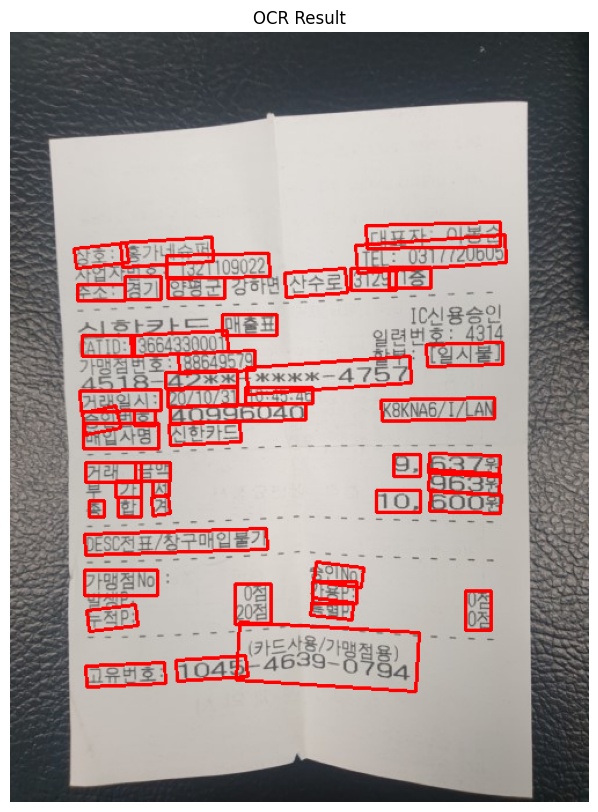

In [12]:
# 시각화된 결과를 파일로 저장
output_path = f'./ocr_result_{current_time}.jpg'
cv2.imwrite(output_path, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))  # RGB -> BGR로 변환 후 저장
plt.figure(figsize=(10, 10))
plt.imshow(show_img)
plt.axis('off')
plt.title("OCR Result")
plt.show()

In [ ]:
os.environ["openai_api_key"] = ""

In [14]:
# ChatOpenAI 챗모델을 초기화합니다.
llm = ChatOpenAI(
    temperature=0.0,  # 창의성 (0.0 ~ 2.0)
    max_tokens=128,  # 최대 토큰수
    model_name="gpt-4o",  # 모델명
)

In [26]:
# template 정의
template = """
영수증 데이터를 분석하여 다음 JSON 형식으로 정리하세요:
{{
"store": "상점명",
"date": "날짜",
"total": "총액",
"items": [
{{ "name": "품목명", "price": 가격 }},
{{ "name": "품목명", "price": 가격 }},
...
]
}}
아래는 분석해야 할 텍스트입니다:
{ocr_result}
"""
# "{ocr_result}: OCR로 추출한 텍스트들이야. 상품명이랑 가격부분만 잘 못된 부분이 있는지 확인해줘"

# from_template 메소드를 이용하여 PromptTemplate 객체 생성
prompt_template = PromptTemplate.from_template(template)
prompt_template

PromptTemplate(input_variables=['ocr_result'], template='\n영수증 데이터를 분석하여 다음 JSON 형식으로 정리하세요:\n{{\n"store": "상점명",\n"date": "날짜",\n"total": "총액",\n"items": [\n{{ "name": "품목명", "price": 가격 }},\n{{ "name": "품목명", "price": 가격 }},\n...\n]\n}}\n아래는 분석해야 할 텍스트입니다:\n{ocr_result}\n')

In [27]:
# prompt 생성
prompt = prompt_template.format(ocr_result=text_result)
prompt

'\n영수증 데이터를 분석하여 다음 JSON 형식으로 정리하세요:\n{\n"store": "상점명",\n"date": "날짜",\n"total": "총액",\n"items": [\n{ "name": "품목명", "price": 가격 },\n{ "name": "품목명", "price": 가격 },\n...\n]\n}\n아래는 분석해야 할 텍스트입니다:\n대표자:이봉순 상호: 홍가네슈퍼 "1321109022 TEL:0317720665 경기 곤육8 산수로 3129 1층 주소: 매출표 ATID: 3664330001 88649579 [롬/Y] 42개 노t-**x :Y 20/10/31 10:45:46 호 40996040 K8KNA6/I/LAN 승인 매입사명 신한카드 거래 금액 9 637원 963원 가 FY 총 부 겨 10 600원 DESC전표/창구입불가 가맹점N N공 20첨 가용P: 특별 정장 누적: 용설음합 :후표공대 1045\n'

In [28]:
# 질의
answer = llm.stream(prompt)
for token in answer:
    print(token.content, end="", flush=True)

주어진 영수증 데이터를 분석하여 JSON 형식으로 정리하면 다음과 같습니다:

```json
{
  "store": "홍가네슈퍼",
  "date": "2020-10-31",
  "total": 10600,
  "items": [
    { "name": "품목명1", "price": 9637 },
    { "name": "품목명2", "price": 963 }
  ]
}
```

이 JSON은 영수증에서 추출한 정보를 기반으로 작성되었습니다. 영수증에 명시된 품목명과 가격이